In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from numpy.random import default_rng
from theano import tensor as tt

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

#### Code 16.1

In [3]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
# scale observed variables
d["w"] = d["weight"] / d["weight"].mean()
d["h"] = d["height"] / d["height"].mean()

#### Code 16.2

In [5]:
with pm.Model() as m16_1:
    sigma = pm.Exponential("sigma", 1)
    k = pm.Exponential("k", 0.5)
    p = pm.Beta("p", alpha=2, beta=18)
    mu = pm.Deterministic("mu", pm.math.log(np.pi * k * tt.pow(p, 2) * tt.pow(d.h, 3)))
    w = pm.Lognormal("w", mu, sigma, observed=d.w)

A prior predictive check is not done in the book, but it is alluded to: the author acknowledges that the priors could be improved, but the data will drive the posterior. So let's have a look at how bad these priors are.

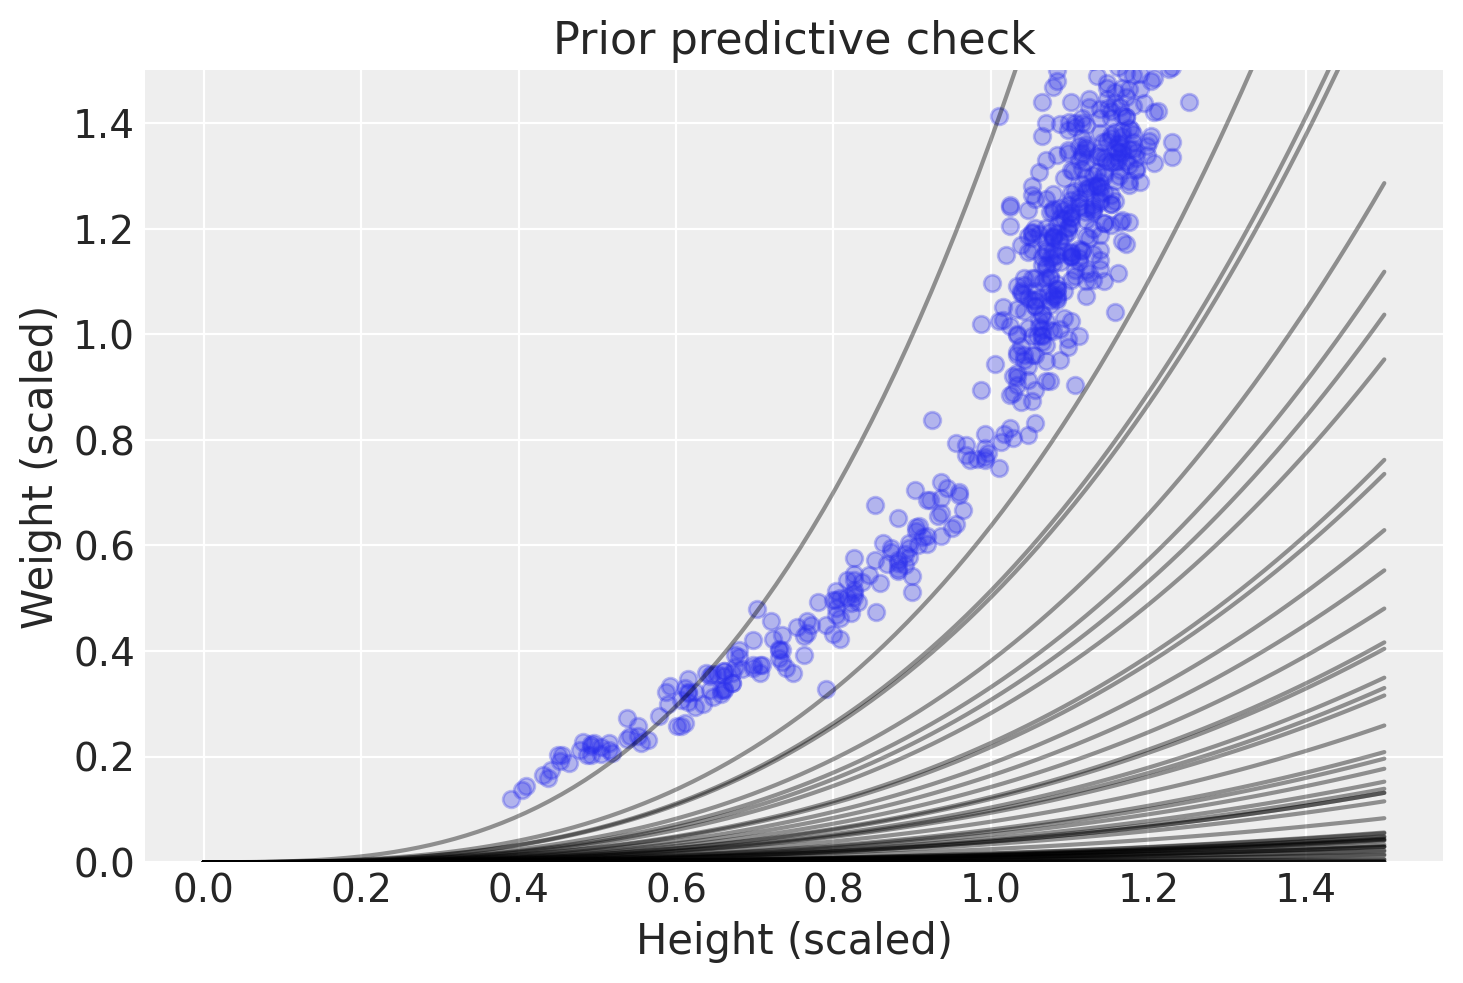

In [6]:
with m16_1:
    prior_checks = pm.sample_prior_predictive(samples=50)

_, ax = plt.subplots()
h_ppc = np.linspace(0, 1.5, 100)

for k, p in zip(prior_checks["k"], prior_checks["p"]):
    w_ppc = np.pi * k * p ** 2 * h_ppc ** 3
    ax.plot(h_ppc, w_ppc, c="k", alpha=0.4)

ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.set_ylim([0, 1.5])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)")
ax.set_title("Prior predictive check");

So clearly some refinement in the priors could be made (e.g. try $k \sim \rm{Exp}(0.25)$ and $p \sim \rm{Beta}(2, 5)$), but let's stick with the priors in the book.

In [7]:
with m16_1:
    trace_16_1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, k, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
varnames = ["~mu"]
az.summary(trace_16_1, kind="stats", var_names=varnames)

,mean,sd,hdi_5.5%,hdi_94.5%
sigma,0.207,0.006,0.197,0.216
k,5.752,2.898,1.947,9.451
p,0.249,0.060,0.159,0.344


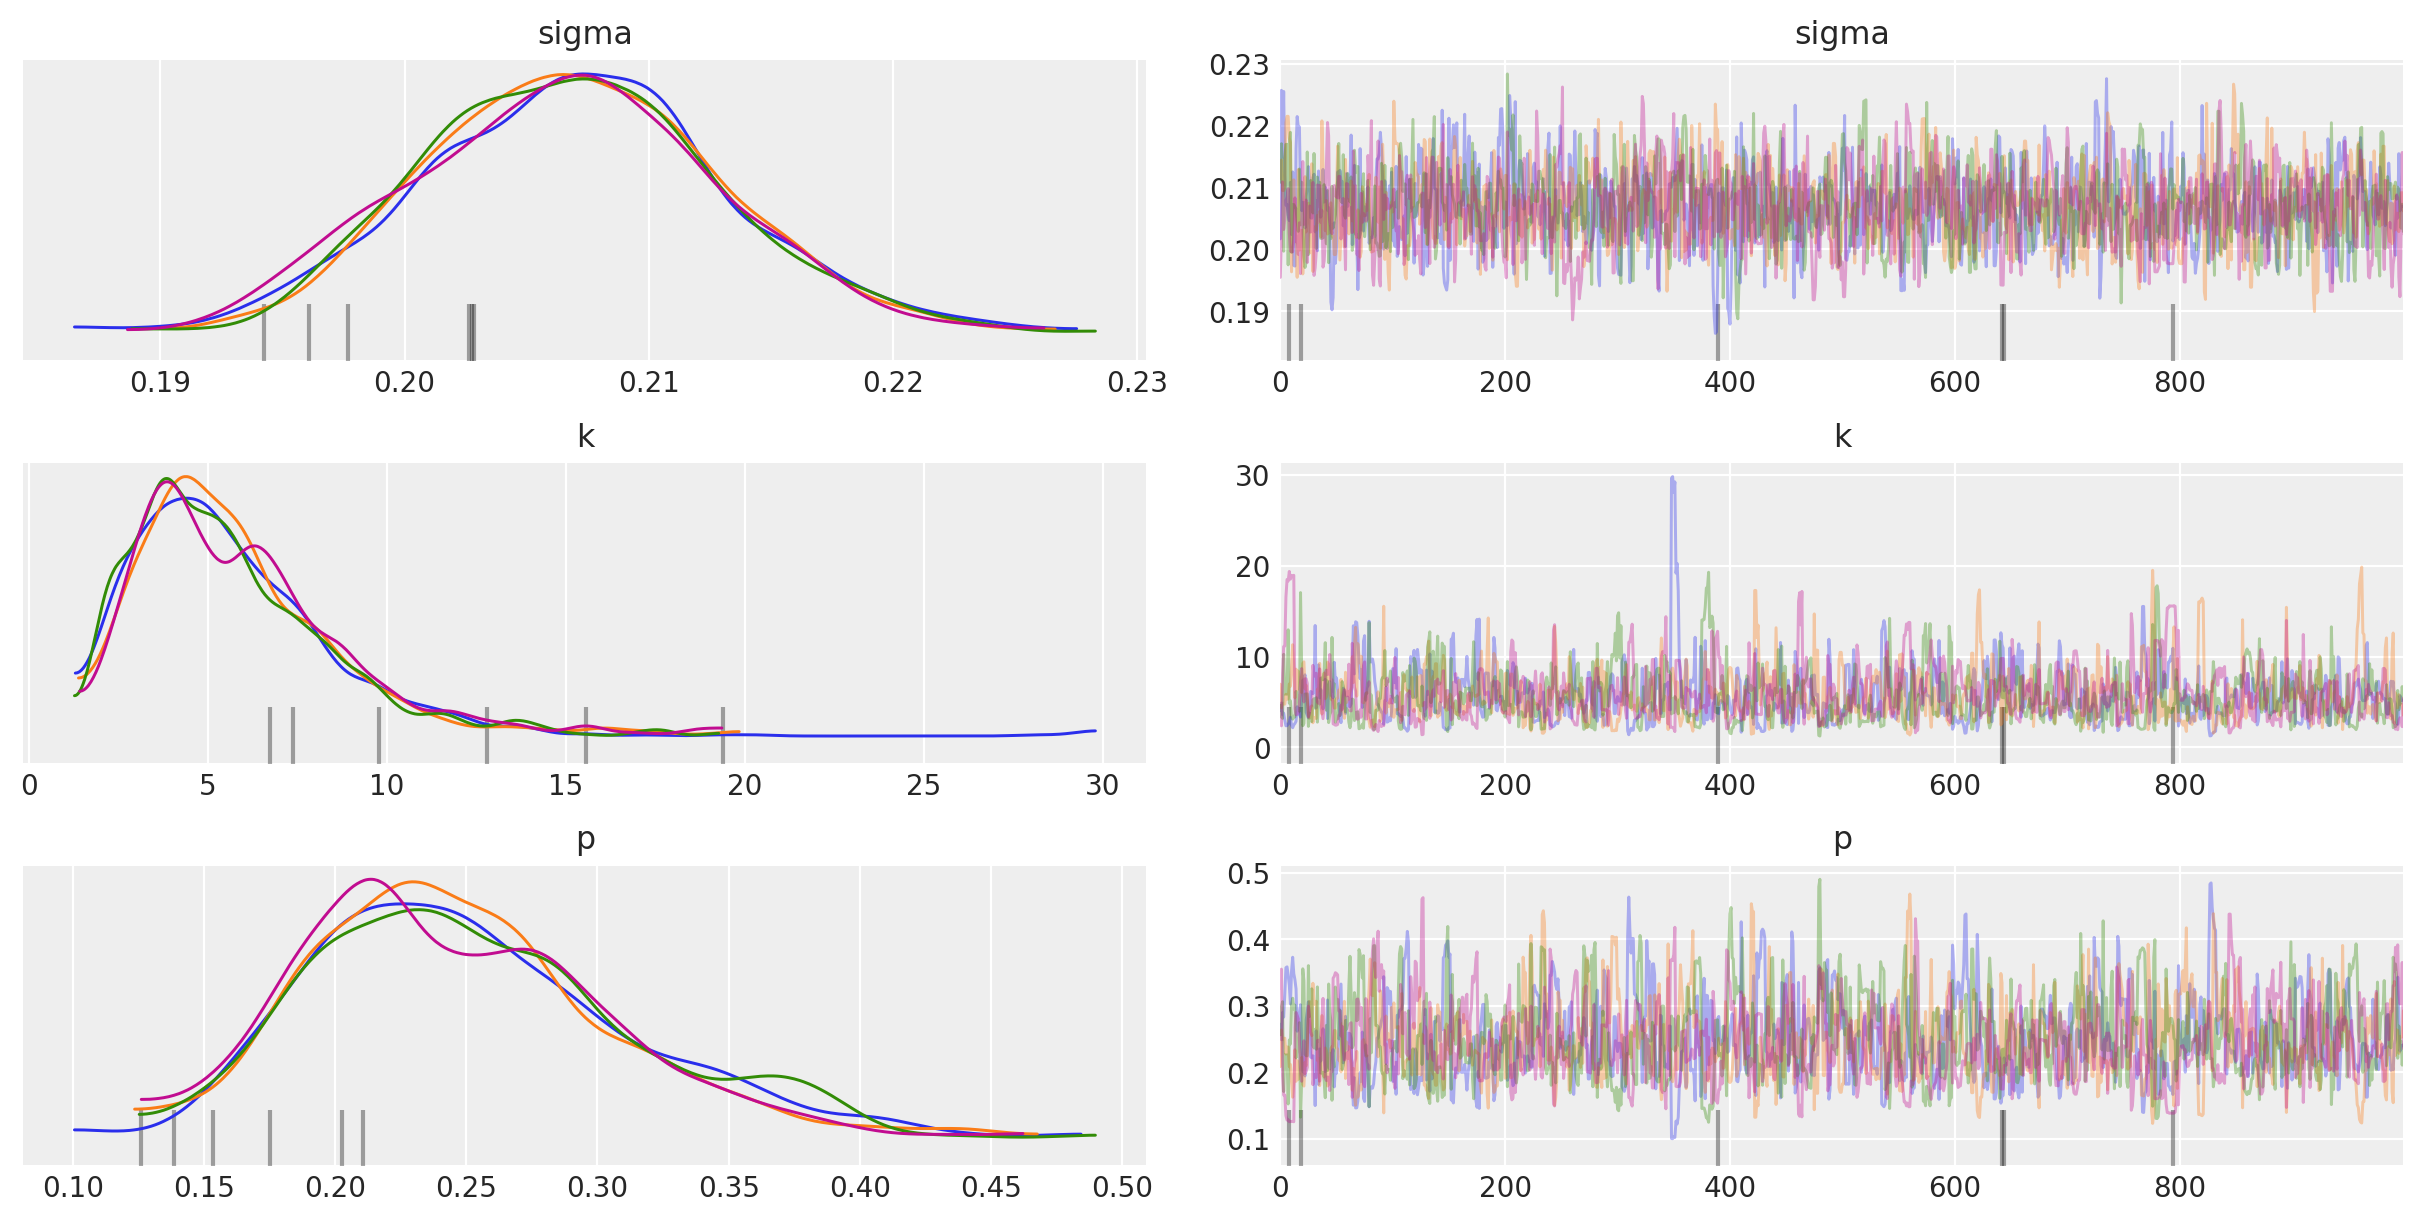

In [9]:
az.plot_trace(trace_16_1, varnames);

The divergences/warnings give us a clue that something in the model isn't working very well. The book explores this through the pairs plot of `k` and `p`

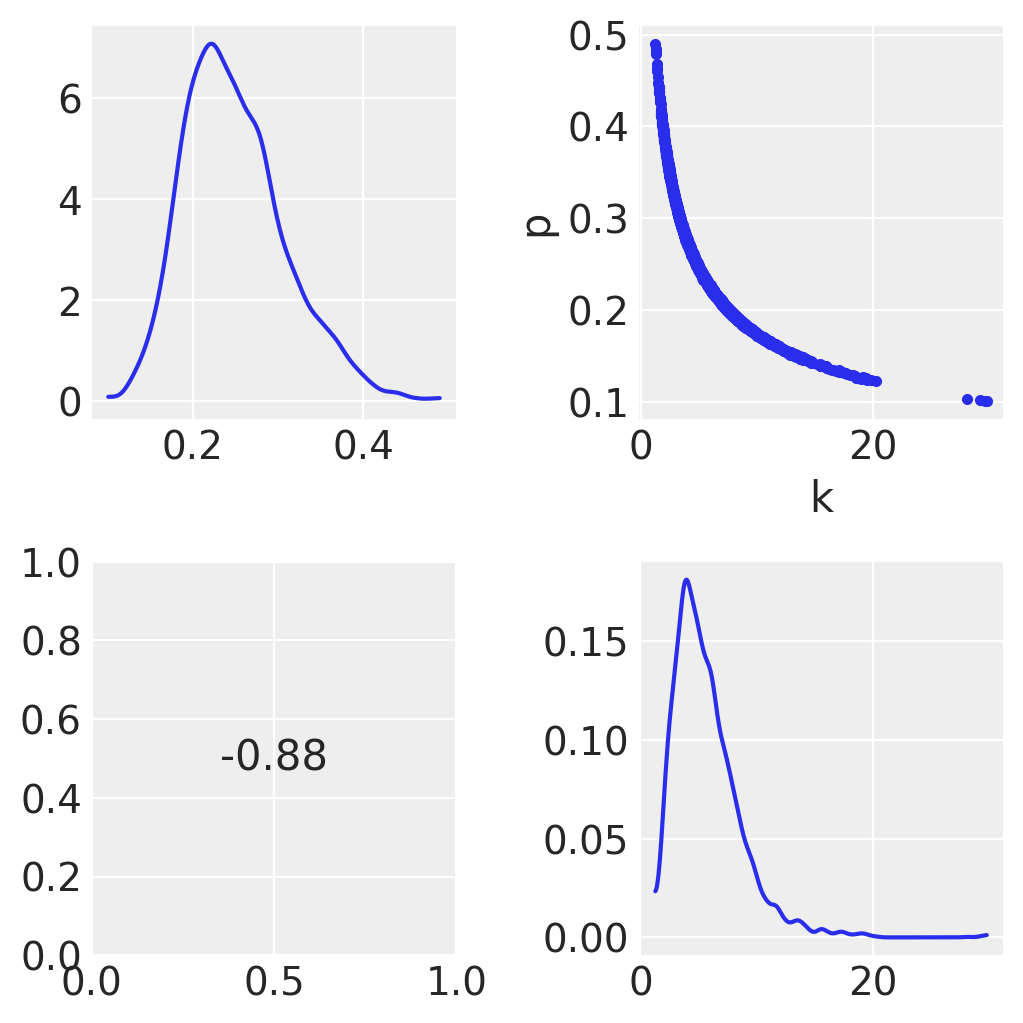

In [10]:
# Replicates Fig 16.2 (left) in the text
_, axes = plt.subplots(2, 2, figsize=(5, 5))
az.plot_kde(trace_16_1["p"], ax=axes[0, 0])
az.plot_pair(trace_16_1, var_names=["k", "p"], kind="scatter", ax=axes[0, 1])
az.plot_kde(trace_16_1["k"], ax=axes[1, 1])
corr = np.corrcoef(trace_16_1["p"], trace_16_1["k"])[0, 1]
axes[1, 0].text(
    0.5,
    0.5,
    f"{corr:.2f}",
    fontsize=15,
    verticalalignment="center",
    horizontalalignment="center",
);

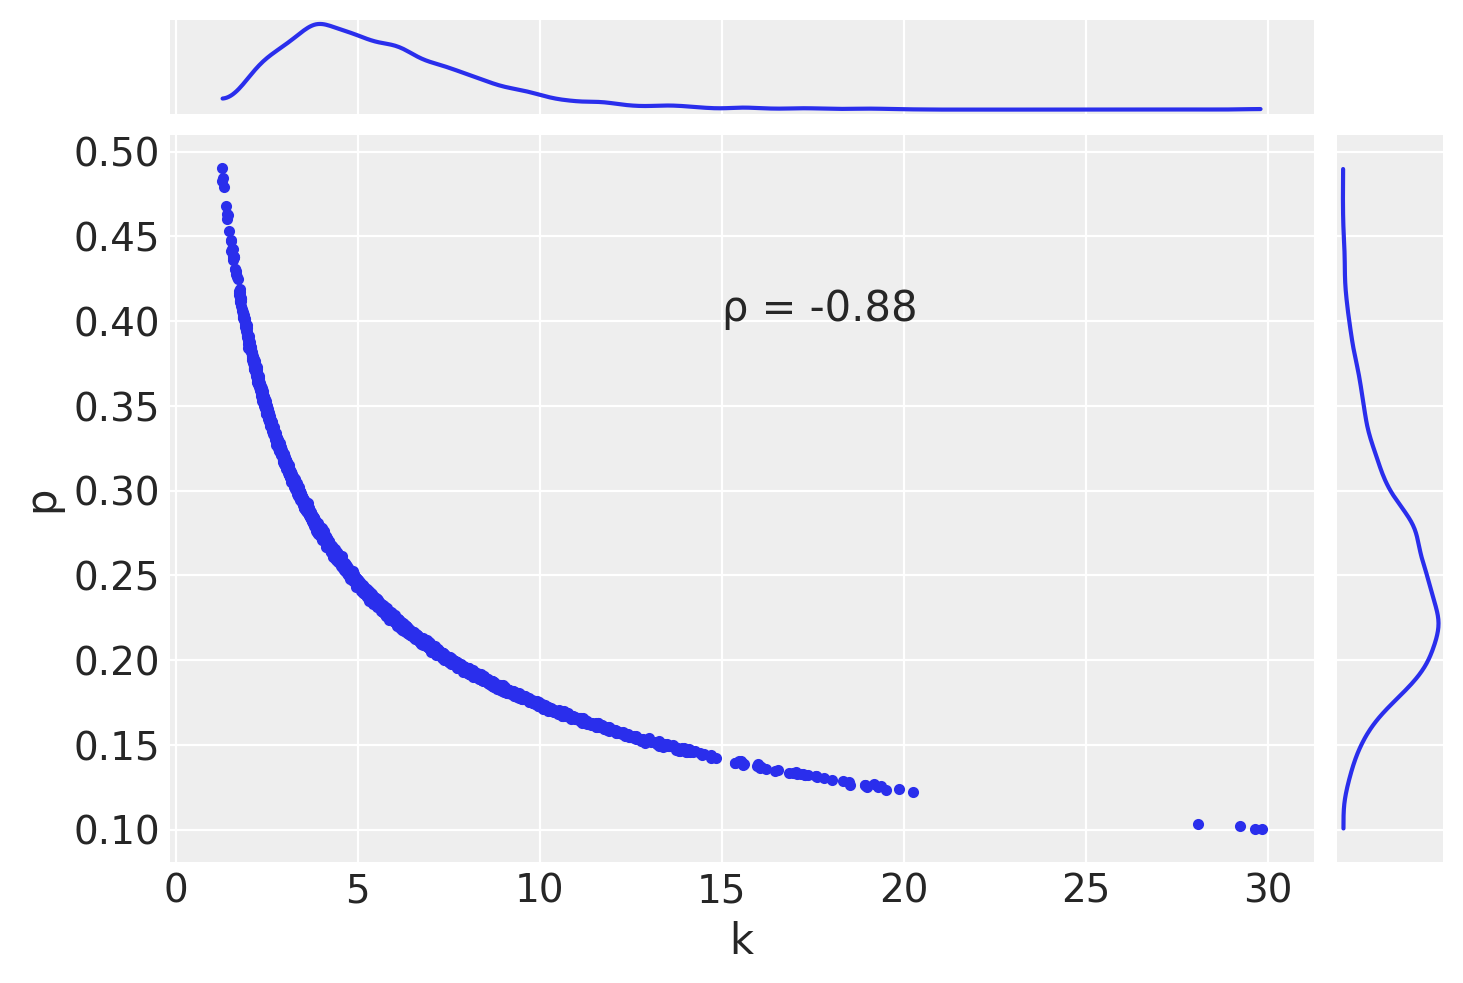

In [11]:
# A more native pymc3/Arviz representation
axes = az.plot_pair(trace_16_1, var_names=["k", "p"], kind="scatter", marginals=True)
corr = np.corrcoef(trace_16_1["p"], trace_16_1["k"])[0, 1]
axes[1, 0].text(15, 0.4, f"ρ = {corr:.2f}", fontsize=15);

The narrow curved ridge is caused by combinations of `p` and `k` where the product $kp^2$ is a constant.

#### Code 16.3

It is possible to draw the hpd for the entire range of `h_seq` below, by manually resampling the model from the Lognormal distribution, but here we are satisfied with the _Arviz_ hpd region which covers the range of the data.

In [12]:
w_sim = pm.sample_posterior_predictive(trace_16_1, 200, m16_1)
h_seq = np.linspace(0, d.h.max(), 30)
mu_mean = np.pi * (trace_16_1["k"] * trace_16_1["p"] ** 2).mean() * h_seq ** 3

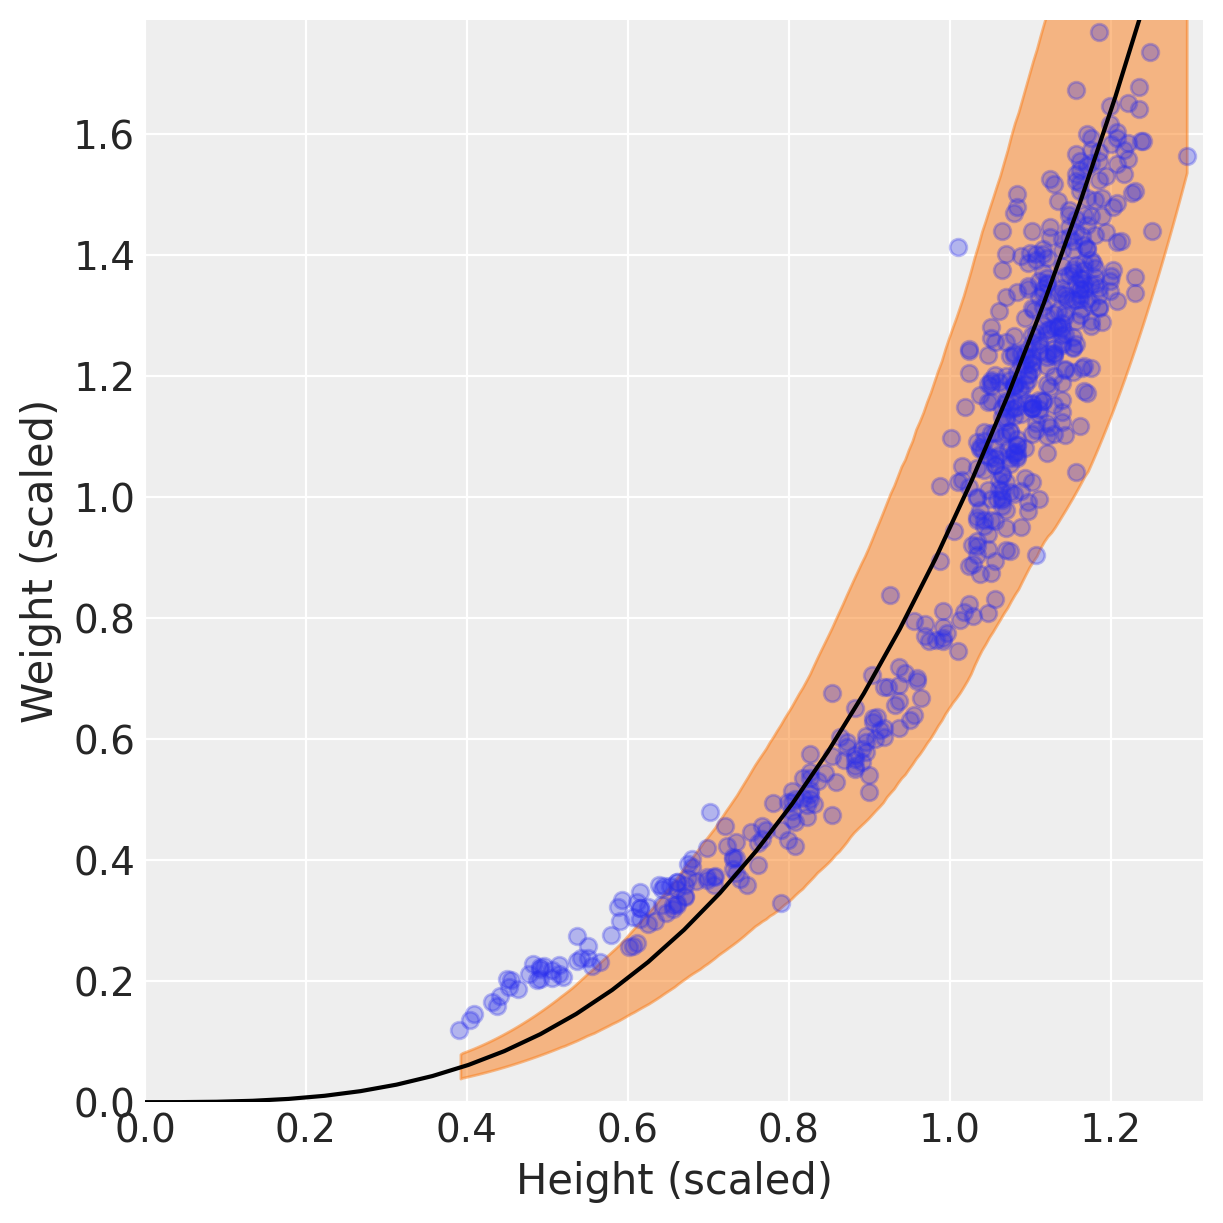

In [13]:
# Fig 16.2 (right) in the text
_, ax = plt.subplots(figsize=(6, 6))
az.plot_hdi(d.h, w_sim["w"], ax=ax)
ax.scatter(d.h, d.w, c="C0", alpha=0.3)
ax.plot(h_seq, mu_mean, "k")
ax.set_xlim([0, d.h.max() + 0.02])
ax.set_ylim([0, d.w.max() + 0.02])
ax.set_xlabel("Height (scaled)")
ax.set_ylabel("Weight (scaled)");

Note there seems to be an error in Figure 16.2 of the book, as the axes limits are unit-scaled, whereas the mean of the data should appear at coordinates 1.0.

#### Code 16.4

In [14]:
df = pd.read_csv("Data/Boxes.csv", delimiter=";")
df.describe()

,y,gender,age,majority_first,culture
count,629.000000,629.000000,629.000000,629.000000,629.000000
mean,2.120827,1.505564,8.030207,0.484897,3.751987
std,0.727986,0.500367,2.497906,0.500170,1.960319
min,1.000000,1.000000,4.000000,0.000000,1.000000
25%,2.000000,1.000000,6.000000,0.000000,3.000000
50%,2.000000,2.000000,8.000000,0.000000,3.000000
75%,3.000000,2.000000,10.000000,1.000000,5.000000
max,3.000000,2.000000,14.000000,1.000000,8.000000


#### Code 16.5

In [15]:
df["y"].value_counts(normalize=True, sort=False)

1    0.211447
2    0.456280
3    0.332273
Name: y, dtype: float64

#### Code 16.6

In [16]:
N = 30  # number of children

# half are random
# sample from 1, 2, 3 at random for each
y1 = np.random.randint(low=1, high=4, size=N // 2)

y2 = np.full(shape=N // 2, fill_value=2)

y = np.random.permutation(np.hstack((y1, y2)))
np.sum(y == 2) / N

0.7333333333333333

#### Code 16.7

In [17]:
def StrategyMixture(p, majority_first):
    def logp(y):
        phi = [None] * 5

        # Probability of data
        phi[0] = tt.switch(tt.eq(y, 2), 1, 0)
        phi[1] = tt.switch(tt.eq(y, 3), 1, 0)
        phi[2] = tt.switch(tt.eq(y, 1), 1, 0)
        phi[3] = tt.ones_like(y) * 1 / 3
        phi[4] = tt.switch(
            tt.eq(majority_first, 1), tt.switch(tt.eq(y, 2), 1, 0), tt.switch(tt.eq(y, 3), 1, 0)
        )

        # Compute log ( p_s * Pr(y_i|s) )
        for i in range(5):
            phi[i] = tt.log(phi[i]) + tt.log(p[i])

        # Compute average log-probability of y_i
        return tt.sum(pm.math.logsumexp(phi, axis=0))

    return logp


with pm.Model() as m16_2:
    # prior
    p = pm.Dirichlet("p", np.array([4, 4, 4, 4, 4]))

    # likelihood
    y = pm.DensityDist("y", StrategyMixture(p, df["majority_first"]), observed=df["y"])

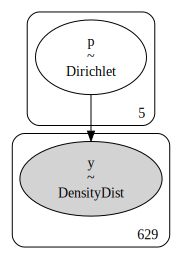

In [18]:
pm.model_to_graphviz(m16_2)

#### Code 16.8

In [19]:
with m16_2:
    m16_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.700100016949934, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


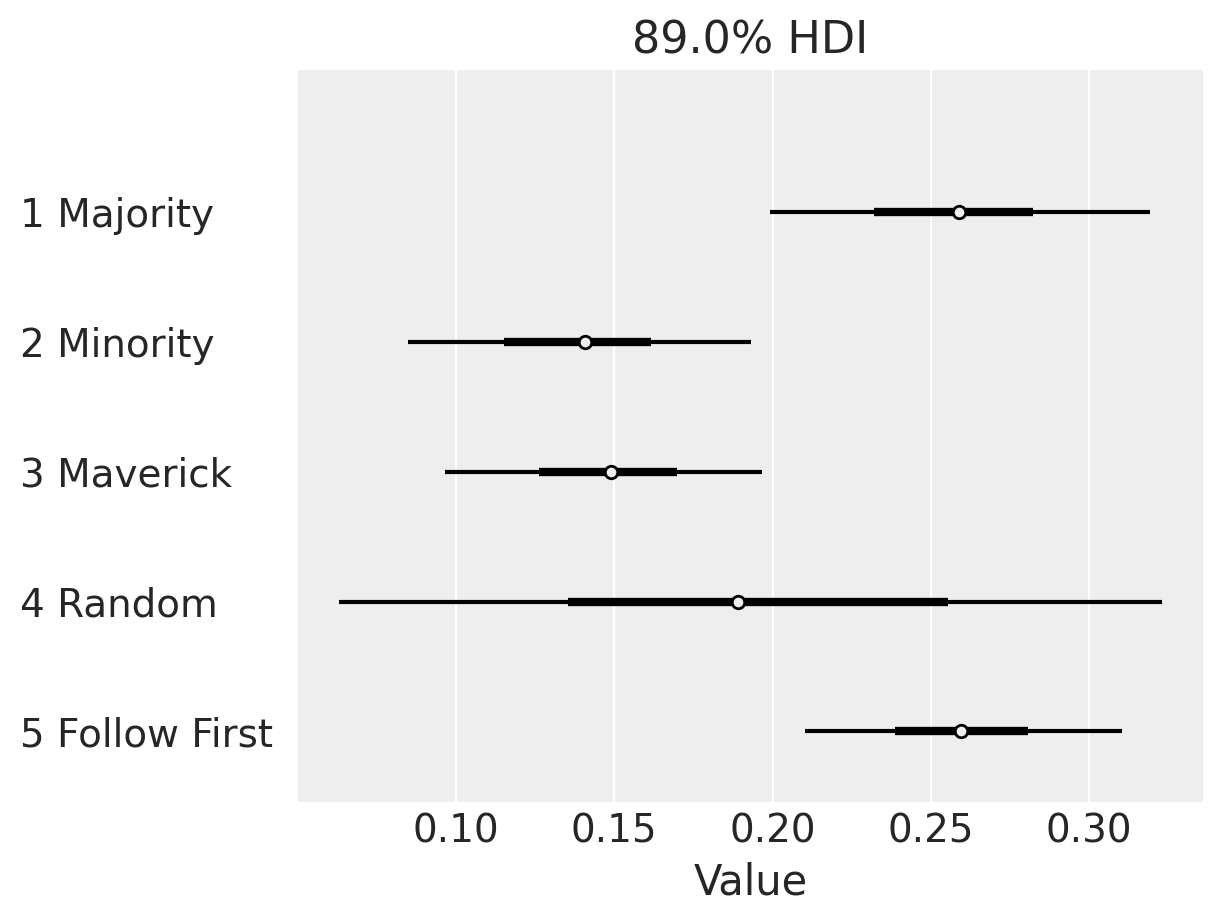

In [20]:
ax = az.plot_forest(m16_2_trace, combined=True, colors="black")

ax = ax[0]
ax.set_yticklabels(
    ["5 Follow First", "4 Random", "3 Maverick", "2 Minority", "1 Majority"], ha="left"
)
ax.get_yaxis().set_tick_params(pad=100)
ax.set_xlabel("Value");

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.0.3
numpy  1.18.2
pymc3  3.9.2
arviz  0.10.0
last updated: Wed Dec 09 2020 

CPython 3.8.5
IPython 7.13.0
watermark 2.0.2
